# Modeling

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
# set a default them for all my visuals
sns.set_theme(style="whitegrid")

# modeling
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# for knn
from sklearn.neighbors import KNeighborsClassifier

# for decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# for random forest
from sklearn.ensemble import RandomForestClassifier

# for logistic regression
from sklearn.linear_model import LogisticRegression

# system manipulation
from itertools import combinations
import os
import sys
sys.path.append("../util_")
import prepare_
import explore_

# other
import math
import env
import warnings
warnings.filterwarnings("ignore")

# set the random seed
np.random.seed(95)

**Get data**

In [2]:
# This data is already been split and save
# This is only training data
train_scaled = pd.read_csv("../00_project_data/1-1_training_data.csv", index_col=0)
train_scaled = train_scaled.reset_index(drop=True)

# validation data
val_scaled = pd.read_csv("../00_project_data/1-2_validation_data.csv", index_col=0)
val_scaled = val_scaled.reset_index(drop=True)

# validation data
test_scaled = pd.read_csv("../00_project_data/1-3_testing_data.csv", index_col=0)
test_scaled = test_scaled.reset_index(drop=True)

train_scaled.head()

,fixed_acidity_scaled,volatile_acidity_scaled,citric_acid_scaled,residual_sugar_scaled,chlorides_scaled,free_sulfur_dioxide_scaled,total_sulfur_dioxide_scaled,density_scaled,ph_scaled,sulphates_scaled,alcohol_scaled,quality,wine_clr,red,white,clusters_3
0,0.173554,0.144,0.195122,0.058065,0.074725,0.173010,0.349515,0.225528,0.705426,0.289773,0.478261,5,white,0,1,1
1,0.297521,0.248,0.186992,0.206452,0.046154,0.186851,0.332871,0.297111,0.325581,0.113636,0.362319,5,white,0,1,1
2,0.338843,0.488,0.170732,0.048387,0.149451,0.214533,0.374480,0.391979,0.410853,0.164773,0.275362,5,red,1,0,2
3,0.165289,0.168,0.040650,0.006452,0.057143,0.062284,0.066574,0.228116,0.496124,0.073864,0.173913,5,white,0,1,1
4,0.181818,0.080,0.219512,0.029032,0.169231,0.262976,0.380028,0.223803,0.596899,0.227273,0.405797,6,white,0,1,1


**Bin taget for modeling**

In [3]:
# separate low quality from high quality wine
train_scaled['quality_bin'] = train_scaled.quality.astype(str).str.replace(r'\b[3-5]\b', '0',regex=True).str.replace(r'\b[6-9]\b', '1',regex=True).astype(int)
val_scaled['quality_bin'] = val_scaled.quality.astype(str).str.replace(r'\b[3-5]\b', '0',regex=True).str.replace(r'\b[6-9]\b', '1',regex=True).astype(int)
test_scaled['quality_bin'] = test_scaled.quality.astype(str).str.replace(r'\b[3-5]\b', '0',regex=True).str.replace(r'\b[6-9]\b', '1',regex=True).astype(int)


In [4]:
train_scaled.head(1)

,fixed_acidity_scaled,volatile_acidity_scaled,citric_acid_scaled,residual_sugar_scaled,chlorides_scaled,free_sulfur_dioxide_scaled,total_sulfur_dioxide_scaled,density_scaled,ph_scaled,sulphates_scaled,alcohol_scaled,quality,wine_clr,red,white,clusters_3,quality_bin
0,0.173554,0.144,0.195122,0.058065,0.074725,0.17301,0.349515,0.225528,0.705426,0.289773,0.478261,5,white,0,1,1,0


**Encode cluster column**

In [6]:
# give the cluster valide names
train_scaled.clusters_3 = train_scaled.clusters_3.astype(str).str.replace(
    "0","density and volatile acid (high, low)").str.replace(
    "1", "density and volatile acid (low, low)").str.replace(
    "2","density and volatile acid (high, high)")

# apply to validate
# give the cluster valide names
val_scaled.clusters_3 = val_scaled.clusters_3.astype(str).str.replace(
    "0","density and volatile acid (high, low)").str.replace(
    "1", "density and volatile acid (low, low)").str.replace(
    "2","density and volatile acid (high, high)")

# apply to validate
# give the cluster valide names
test_scaled.clusters_3 = test_scaled.clusters_3.astype(str).str.replace(
    "0","density and volatile acid (high, low)").str.replace(
    "1", "density and volatile acid (low, low)").str.replace(
    "2","density and volatile acid (high, high)")


In [7]:
# get cluster dummies
cluster_dummies = pd.get_dummies(train_scaled.clusters_3)
val_cluster_dummies = pd.get_dummies(val_scaled.clusters_3)
test_cluster_dummies = pd.get_dummies(test_scaled.clusters_3)

# new cleaned column names
cluster_col = cluster_dummies.columns.str.replace(" ","_").str.lower()

# add the dummies to the dataframe
train_scaled[cluster_col] = cluster_dummies
val_scaled[cluster_col] = val_cluster_dummies
test_scaled[cluster_col] = test_cluster_dummies
train_scaled.head(2)

,fixed_acidity_scaled,volatile_acidity_scaled,citric_acid_scaled,residual_sugar_scaled,chlorides_scaled,free_sulfur_dioxide_scaled,total_sulfur_dioxide_scaled,density_scaled,ph_scaled,sulphates_scaled,alcohol_scaled,quality,wine_clr,red,white,clusters_3,quality_bin,"density_and_volatile_acid_(high,_high)","density_and_volatile_acid_(high,_low)","density_and_volatile_acid_(low,_low)"
0,0.173554,0.144,0.195122,0.058065,0.074725,0.173010,0.349515,0.225528,0.705426,0.289773,0.478261,5,white,0,1,"density and volatile acid (low, low)",0,0,0,1
1,0.297521,0.248,0.186992,0.206452,0.046154,0.186851,0.332871,0.297111,0.325581,0.113636,0.362319,5,white,0,1,"density and volatile acid (low, low)",0,0,0,1


**Separate feature from target**

In [8]:
# assign features and labels for the model
xtrain = train_scaled[np.append(cluster_col, ["white", "free_sulfur_dioxide_scaled", 
                                              "alcohol_scaled", "density_scaled", "volatile_acidity_scaled"])]
ytrain = train_scaled.quality_bin

# validate
xval = val_scaled[np.append(cluster_col, ["white","free_sulfur_dioxide_scaled", 
                                          "alcohol_scaled", "density_scaled", "volatile_acidity_scaled"])]
yval = val_scaled.quality_bin

# test
xtest = test_scaled[np.append(cluster_col, ["white","free_sulfur_dioxide_scaled", 
                                          "alcohol_scaled", "density_scaled", "volatile_acidity_scaled"])]
ytest = test_scaled.quality_bin

**Set baseline**

In [9]:
# calculate and add bseline to the training data
train_scaled["baseline"] = int(ytrain.mode())

# baseline score
baseline =accuracy_score( ytrain, train_scaled.baseline)
baseline

0.6259398496240601

## KNN

Train KNN model on different k values.

In [10]:
# the maximun number of neighbors the model should look at
# in my case it can only look at 1% of the data
k_neighbors = math.ceil(len(xtrain) * 0.01)

# the final result metric
metrics = []

for k in range(1, k_neighbors + 1):
    # create a knn object
    #                          n_neighborsint(default=5) 
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=2)
    #                                                        p=1 uses the manhattan distance

    # fit training data to the object
    knn = knn.fit(xtrain, ytrain)
    
    #USE the thing
    train_score= knn.score(xtrain, ytrain)
    validate_score = knn.score(xval, yval)
    
    # create a dictionary of scores
    output = {
        "k": k,
        "train_score": train_score,
         "validate_score": validate_score,
        "difference": train_score - validate_score,
        "train_baseline_diff": baseline - train_score,
        "baseline_accuracy": baseline,
    }
    
    metrics.append(output)

In [11]:
# get the result as a dataframe
knn_model_df = pd.DataFrame(metrics)
knn_model_df.head()

,k,train_score,validate_score,difference,train_baseline_diff,baseline_accuracy
0,1,1.000000,0.674812,0.325188,-0.374060,0.62594
1,2,0.859023,0.612782,0.246241,-0.233083,0.62594
2,3,0.844612,0.648496,0.196115,-0.218672,0.62594
3,4,0.813910,0.628759,0.185150,-0.187970,0.62594
4,5,0.808897,0.656955,0.151942,-0.182957,0.62594


**Visualize model**

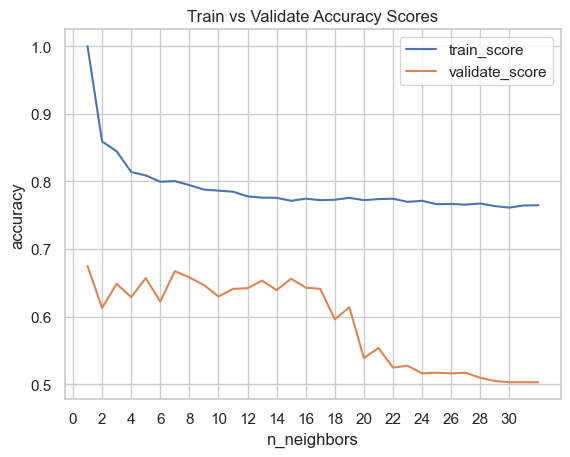

In [12]:
#PLOT train vs validate
knn_model_df[knn_model_df.columns[:-3]].set_index("k").plot()
plt.xticks(np.arange(0,k_neighbors, 2))
plt.ylabel('accuracy')
plt.xlabel('n_neighbors')
plt.title("Train vs Validate Accuracy Scores")
plt.grid(visible=True, axis='both')
plt.show()

7 LOOKS TO BE THE BEST MODEL K

**Best K numbers**

In [13]:
# find the model with smallest ifference between the train and validate
knn_model_df[knn_model_df.k == 7]

,k,train_score,validate_score,difference,train_baseline_diff,baseline_accuracy
6,7,0.800439,0.667293,0.133145,-0.174499,0.62594


## Decision Tree

Train decision tree model on different tree depth


In [14]:
metrics = []
for d in range(1,11):
#      create tree object
    treeClf = DecisionTreeClassifier(max_depth= d, random_state=95)
    
    # fit model
    treeClf = treeClf.fit(xtrain, ytrain)
    
    # train accurecy score
    train_score = treeClf.score(xtrain, ytrain)
    validate_score = treeClf.score(xval, yval)
    
    # create a dictionary of scores
    output = {
        "depth": d,
        "train_score": train_score,
         "validate_score": validate_score,
        "difference": train_score - validate_score,
        "train_baseline_diff": baseline - train_score,
        "baseline_accuracy": baseline,
    }
    
    metrics.append(output)

In [15]:
# get the result as a dataframe
decTree_model_df = pd.DataFrame(metrics)
decTree_model_df.head()

,depth,train_score,validate_score,difference,train_baseline_diff,baseline_accuracy
0,1,0.704261,0.694549,0.009712,-0.078321,0.62594
1,2,0.732769,0.734962,-0.002193,-0.106830,0.62594
2,3,0.732769,0.734962,-0.002193,-0.106830,0.62594
3,4,0.745927,0.705827,0.040100,-0.119987,0.62594
4,5,0.759398,0.696429,0.062970,-0.133459,0.62594


**Visualize model**

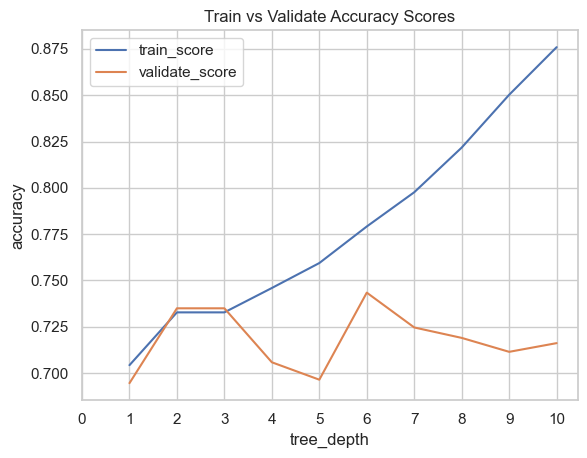

In [16]:
decTree_model_df[decTree_model_df.columns[:-3]].set_index("depth").plot()
plt.ylabel('accuracy')
plt.xlabel('tree_depth')
plt.title("Train vs Validate Accuracy Scores")
plt.xticks(np.arange(0,11))
plt.grid(visible=True, axis='both')
plt.show()

2 LOOKS TO BE THE BEST MODEL DEPTH

**Best depth numbers**


In [17]:
# find the model with smallest ifference between the train and validate
decTree_model_df[decTree_model_df.depth == 3]

,depth,train_score,validate_score,difference,train_baseline_diff,baseline_accuracy
2,3,0.732769,0.734962,-0.002193,-0.10683,0.62594


## Random Forest

Train random forest model on different tree depth

In [18]:
metrics = []

for trees in range(2,20):

    # create ramdom tree object
    randFor = RandomForestClassifier(n_estimators= 100, min_samples_leaf= trees, max_depth = trees, random_state=95 )
    
    # fit the model
    randFor = randFor.fit(xtrain, ytrain)
    
    # get accuracy scores
    train_score = randFor.score(xtrain, ytrain)
    validate_score = randFor.score(xval, yval)
    
    # create a dictionary of scores
    output = {
        "trees": trees,
        "train_score": train_score,
         "validate_score": validate_score,
        "difference": train_score - validate_score,
        "train_baseline_diff": baseline - train_score,
        "baseline_accuracy": baseline,
    }
    
    metrics.append(output)

In [19]:
# get the result as a dataframe
randFor_model_df = pd.DataFrame(metrics)
randFor_model_df.head()

,trees,train_score,validate_score,difference,train_baseline_diff,baseline_accuracy
0,2,0.727130,0.703947,0.023183,-0.101190,0.62594
1,3,0.744048,0.726504,0.017544,-0.118108,0.62594
2,4,0.755639,0.731203,0.024436,-0.129699,0.62594
3,5,0.764724,0.733083,0.031642,-0.138784,0.62594
4,6,0.773810,0.734023,0.039787,-0.147870,0.62594


**Visualize model**

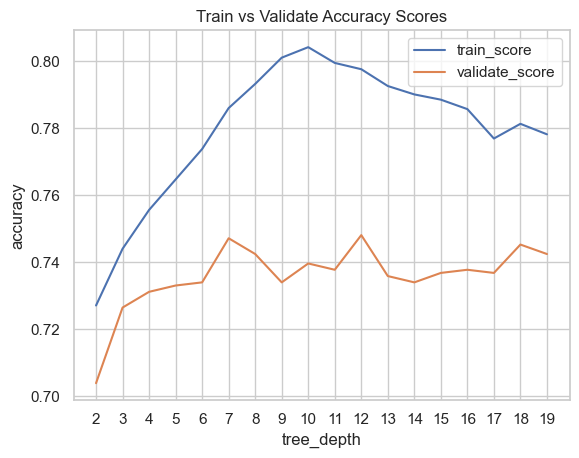

In [20]:
randFor_model_df[randFor_model_df.columns[:-3]].set_index("trees").plot()
plt.ylabel('accuracy')
plt.xlabel('tree_depth')
plt.title("Train vs Validate Accuracy Scores")
plt.xticks(np.arange(2,20))
plt.grid(visible=True, axis='both')
plt.show()

7 LOOKS TO BE THE BEST MODEL TREE DEPTH

**Best depth numbers**

In [21]:
# find the model with smallest ifference between the train and validate
randFor_model_df[randFor_model_df.trees == 7]

,trees,train_score,validate_score,difference,train_baseline_diff,baseline_accuracy
5,7,0.786028,0.74718,0.038847,-0.160088,0.62594


## Logistic Regression

Train logistic regression model on different C

In [22]:
metrics = []

for c in np.arange(0.0001,0.1, 0.01):
    
    # create ramdom tree object
    logReg = LogisticRegression(C=c, random_state=95, max_iter= 1000)
    
    # fit the model
    randFor = logReg.fit(xtrain, ytrain)
    
    # get accuracy scores
    train_score = randFor.score(xtrain, ytrain)
    validate_score = randFor.score(xval, yval)
    
    # create a dictionary of scores
    output = {
        "c": c,
        "train_score": train_score,
         "validate_score": validate_score,
        "difference": train_score - validate_score,
        "train_baseline_diff": baseline - train_score,
        "baseline_accuracy": baseline,
    }
    
    metrics.append(output)

In [23]:
# get the result as a dataframe
logReg_model_df = pd.DataFrame(metrics)
logReg_model_df.head()

,c,train_score,validate_score,difference,train_baseline_diff,baseline_accuracy
0,0.0001,0.625940,0.626880,-0.000940,0.000000,0.62594
1,0.0101,0.683271,0.598684,0.084586,-0.057331,0.62594
2,0.0201,0.694236,0.576128,0.118108,-0.068296,0.62594
3,0.0301,0.706767,0.583647,0.123120,-0.080827,0.62594
4,0.0401,0.709586,0.595865,0.113722,-0.083647,0.62594


**Visualize model**

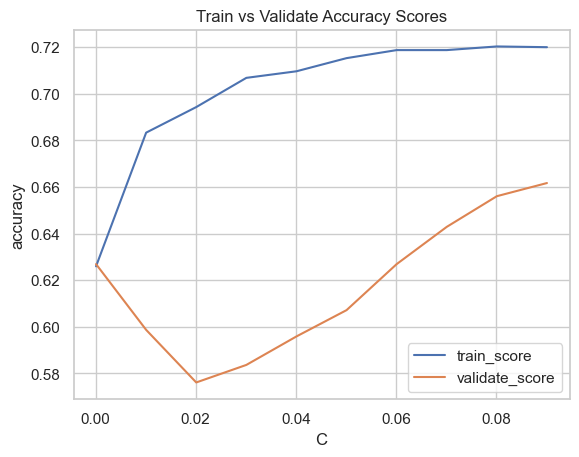

In [24]:
logReg_model_df[logReg_model_df.columns[:-3]].set_index("c").plot()
plt.ylabel('accuracy')
plt.xlabel('C')
plt.title("Train vs Validate Accuracy Scores")
plt.grid(visible=True, axis='both')
plt.show()

3 LOOKS TO BE THE BEST MODEL DEPTH

**Best depth numbers**

In [25]:
# find the model with smallest ifference between the train and validate
logReg_model_df[logReg_model_df.c == 0.0101]

,c,train_score,validate_score,difference,train_baseline_diff,baseline_accuracy
1,0.0101,0.683271,0.598684,0.084586,-0.057331,0.62594


### Test Decision Tree

In [30]:
metrics = []

# create tree object
treeClf = DecisionTreeClassifier(max_depth= 3, random_state=95)

# fit model
treeClf = treeClf.fit(xtrain, ytrain)

# train accurecy score
train_score = treeClf.score(xtrain, ytrain)
validate_score = treeClf.score(xval, yval)
test_score = treeClf.score(xtest, ytest)

# create a dictionary of scores
output = {
    "depth": 3,
    "train_score": train_score,
     "validate_score": validate_score,
    "test_score": test_score,
    "train_test_diff": train_score - test_score,
    "test_baseline_diff": baseline - test_score,
    "baseline_accuracy": baseline,
}
metrics.append(output)

In [31]:
# get the result as a dataframe
decTree_model_df = pd.DataFrame(metrics)
decTree_model_df.head()

,depth,train_score,validate_score,test_score,train_test_diff,test_baseline_diff,baseline_accuracy
0,3,0.732769,0.734962,0.718985,0.013784,-0.093045,0.62594
